In [1]:
%load_ext autoreload
%autoreload 2

import os, json
import nibabel as nb

from keras import metrics 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LocallyConnected1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.utils.vis_utils import plot_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import hrf_estimation
import scipy.signal as signal
import scipy.stats as stats

from joblib import Parallel, delayed

%matplotlib inline

Using TensorFlow backend.


In [2]:
os.chdir('/Users/knapen/projects/prfpy/test/develop/')
from prfpy.rf import *
from prfpy.timecourse import *
from prfpy.stimulus import PRFStimulus2D

In [3]:
x, y = np.meshgrid(np.linspace(-5,5,200), np.linspace(-5,5,200))
compl = x + y * 1j
ecc = np.abs(compl)
polar = np.angle(compl)

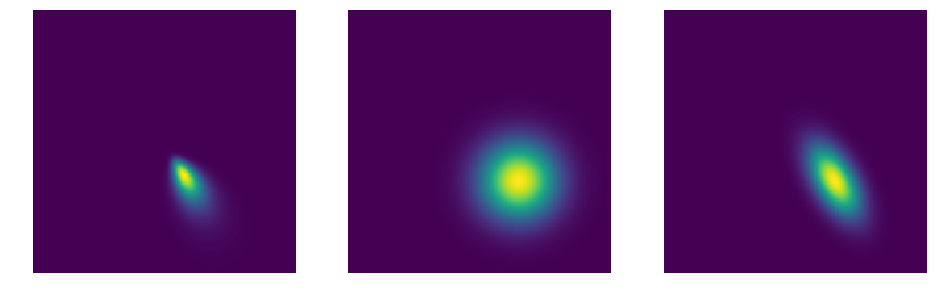

In [4]:
f, ss = plt.subplots(1,3,figsize=(16,6))
ss[0].imshow(gauss2D_logpolar(ecc, polar, mu=(1.5, np.pi/3), sigma=0.38, kappa=30))
ss[0].axis('off')
ss[1].imshow(gauss2D_iso_cart(x, y, mu=(1.5, 1.5), sigma=1.0))
ss[1].axis('off')
ss[2].imshow(gauss2D_rot_cart(x, y, mu=(1.5, 1.5), sigma=1.0, theta=np.pi/3, ar=2.0))
ss[2].axis('off')
plt.savefig("../../docs/imgs/rf_shapes.png")

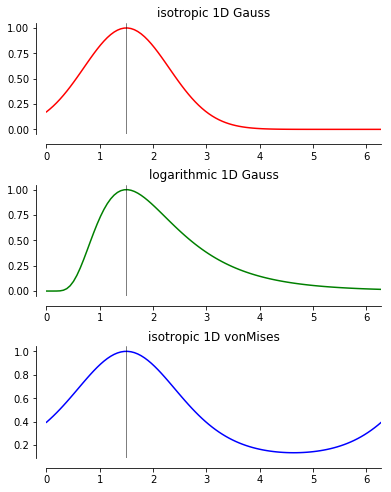

In [11]:
x1D = np.linspace(0,2*np.pi, 100)
m = 1.5
f, ss = plt.subplots(3,1,figsize=(6,8))
ss[0].plot(x1D, gauss1D_cart(x1D, m, 0.8), 'r')
ss[0].set_title('isotropic 1D Gauss')
ss[0].set_xlim([0,2*np.pi])
ss[0].axvline(m, c='k', lw=0.5)
ss[1].plot(x1D, gauss1D_log(x1D, m, 0.5), 'g')
ss[1].set_title('logarithmic 1D Gauss')
ss[1].set_xlim([0,2*np.pi])
ss[1].axvline(m, c='k', lw=0.5)
ss[2].plot(x1D, vonMises1D(x1D, m, 1), 'b')
ss[2].set_title('isotropic 1D vonMises')
ss[2].set_xlim([0,2*np.pi])
ss[2].axvline(m, c='k', lw=0.5)
f.subplots_adjust(hspace=0.45)
sns.despine(offset=10)
plt.savefig("../../docs/imgs/rf_shapes_1D.png")

In [6]:
stim_dm = np.load('../data/dm.npy').T # transpose for final dimension time
prf_stim = PRFStimulus2D(screen_size_cm=70, 
                         screen_distance_cm=125, 
                         design_matrix=stim_dm, 
                         TR=1.6)

grid_nr = 25
max_ecc_size = 20
sizes, eccs, polars = np.meshgrid(
                        max_ecc_size * np.linspace(0.001,1,grid_nr)**2,
                        max_ecc_size * np.linspace(0.001,1,grid_nr)**2,
                        np.linspace(0, 2*np.pi, grid_nr))

mus = np.array([np.sin(polars) * eccs, np.cos(polars) * eccs]).T

In [22]:
%%time
prf_stim.grid_rfs = np.array(
                        Parallel(n_jobs=-1)(
                            delayed(gauss2D_iso_cart)(
                              prf_stim.x_coordinates, prf_stim.y_coordinates, mu=mu, sigma=s) 
                                for mu, s in zip(mus.reshape((-1,2)), sizes.ravel()
                                          )
                        )
                    )

CPU times: user 8.29 s, sys: 13.3 s, total: 21.6 s
Wall time: 24.6 s


In [8]:
%%time
prf_stim.conv_dm = convolve_stimulus_dm(stim_dm, hrf=hrf_estimation.hrf.spmt(np.arange(0,40,prf_stim.TR)))
prf_stim.predictions = stimulus_through_prf(prf_stim.grid_rfs, prf_stim.conv_dm)

CPU times: user 5.52 s, sys: 142 ms, total: 5.66 s
Wall time: 1.52 s


In [9]:
prf_stim.predictions.shape

(15625, 167)

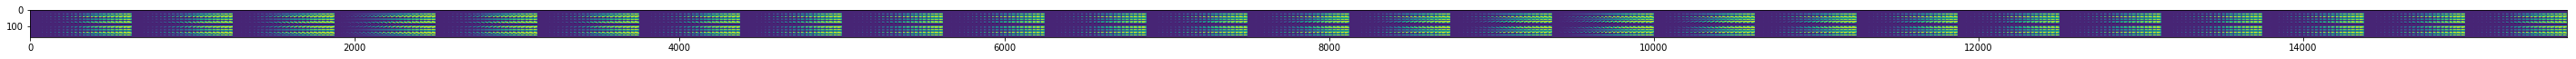

In [10]:
plt.figure(figsize=(50,5))
plt.imshow(prf_stim.predictions.T)

In [14]:
mus.reshape((-1,2)).T.shape

(2, 15625)

In [24]:
%%time
prf_stim.grid_rfs = gauss2D_iso_cart(
                np.tile(prf_stim.x_coordinates[...,np.newaxis], sizes.ravel().shape[0]), 
                np.tile(prf_stim.y_coordinates[...,np.newaxis], sizes.ravel().shape[0]), 
                mu=mus.reshape((-1,2)).T, 
                sigma=sizes.ravel())

CPU times: user 31.8 s, sys: 51.1 s, total: 1min 22s
Wall time: 56.6 s


In [23]:
sizes.ravel().shape

(15625,)